<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

## Description
The idea is to create a virtual radiologist.
Images of possibly cancerous tissue samples are given, 
and the detector must identify where in the tissue cancer may reside.

### Network Architecture
The “Deep Convolution U-Net” is found in this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      #datasets.utils.download_url('https://nolans-cs-bucket.s3-us-west-1.amazonaws.com/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

In [ ]:
# Tests that the output dimensions of the conv transpose layers are correct
a = nn.ConvTranspose2d(1024, 512, kernel_size = (2, 2), stride = 2)
a(torch.zeros(1, 1024, 32, 32)).size()


torch.Size([1, 512, 64, 64])

In [ ]:
# Class for cancer detection network
# Follows the U-Net architecture discussed in this paper: https://arxiv.org/pdf/1505.04597.pdf
class CancerDetection(nn.Module):
  def __init__(self, in_channels):
    super(CancerDetection, self).__init__()
    
    # Blocks of convolutional layers
    self.block1 = ConvolutionBlock(in_channels, 64)
    self.block2 = ConvolutionBlock(64, 128)
    self.block3 = ConvolutionBlock(128, 256)
    self.block4 = ConvolutionBlock(256, 512)
    self.block5 = ConvolutionBlock(512, 1024)
    self.block6 = ConvolutionBlock(1024, 512)
    self.block7 = ConvolutionBlock(512, 256)
    self.block8 = ConvolutionBlock(256, 128)
    self.block9 = ConvolutionBlock(128, 64)
    
    # Maxpool function that is used after the first 4 blocks
    self.maxpool = nn.MaxPool2d(2)
    
    # Transpose convolutions that are used to up-sample after blocks 5 through 8
    self.conv_transpose5 = nn.ConvTranspose2d(1024, 512, kernel_size = (2, 2), stride = 2)
    self.conv_transpose6 = nn.ConvTranspose2d(512, 256, kernel_size = (2, 2), stride = 2)
    self.conv_transpose7 = nn.ConvTranspose2d(256, 128, kernel_size = (2, 2), stride = 2)
    self.conv_transpose8 = nn.ConvTranspose2d(128, 64, kernel_size = (2, 2), stride = 2)
    
    # Final convolution applied after the last block (block 9)
    self.final_conv = nn.Conv2d(64, 2, kernel_size = (1, 1), stride = 1)
    
    # Softmax that is used to convert the final output from a vector of scores to a vector of probabilities
    self.soft_max = nn.Softmax2d()
 
  def forward(self, x):
    # Run the U-Net model
    o1 = self.block1(x)
    o1_max = self.maxpool(o1)
    
    o2 = self.block2(o1_max)
    o2_max = self.maxpool(o2)
    
    o3 = self.block3(o2_max)
    o3_max = self.maxpool(o3)
    
    o4 = self.block4(o3_max)
    o4_max = self.maxpool(o4)
    
    o5 = self.block5(o4_max)
    o5_up = self.conv_transpose5(o5)
    
    o6_concat = torch.cat((o4, o5_up), 1)
    o6 = self.block6(o6_concat)
    o6_up = self.conv_transpose6(o6)
    
    o7_concat = torch.cat((o3, o6_up), 1)
    o7 = self.block7(o7_concat)
    o7_up = self.conv_transpose7(o7)
    
    o8_concat = torch.cat((o2, o7_up), 1)
    o8 = self.block8(o8_concat)
    o8_up = self.conv_transpose8(o8)
    
    o9_concat = torch.cat((o1, o8_up), 1)
    o9 = self.block9(o9_concat)
    
    # Apply the final convolution and softmax and return the results
    final_results = self.final_conv(o9)
    
    return final_results
  

# Class for representing blocks of convolutional layers
class ConvolutionBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvolutionBlock, self).__init__()
    
    self.net = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = (3, 3), stride = 1, padding = (1, 1)),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size = (3, 3), stride = 1, padding = (1, 1)),
      nn.ReLU()
    )
  
  def forward(self, x): 
    return self.net(x)
    


In [ ]:
# Initialize Datasets
train_dataset = CancerDataset('/tmp/cancerdata', train = True, size = 256)

validate_dataset = CancerDataset('/tmp/cancerdata', train = False, size = 256)

# Extract dimensions of the dataset
channels, height, width = train_dataset[0][0].size()

# Set desired batch size and number of epochs
batch_size = 10
n_epochs = 10

# Initialize the U-Net model and put it in GPU
model = CancerDetection(channels)
model = model.cuda()

# Initialize objective and optimizer
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
# Helper function for computing accuracy
# This function iterates through every batch, calculates the total number of 
#  correct pixels our model predicted, and divides that number by the total 
#  number of pixels in the image
def compute_accuracy(y_hat, y_truth):
  batch_accuracy = []
  batch_size, c, h, w = y_hat.size()
  
  num_pixels = h * w
  
  for i in range(batch_size):
    y_hat1 = torch.softmax(y_hat[i], 0)
    pred = y_hat1.argmax(0).float()
    
    true_cancer = y_truth[i]
    true_not_cancer = 1 - y_truth[i]
    
    pred_cancer = pred
    pred_not_cancer = 1 - pred
    
    true_cancer_vals = torch.sum(true_cancer * pred_cancer)
    true_not_cancer_vals = torch.sum(true_not_cancer * pred_not_cancer)
    
    accuracy = ((true_cancer_vals + true_not_cancer_vals) / num_pixels).item()
    
    batch_accuracy.append(accuracy)
    
  return np.mean(batch_accuracy)

# Helper function for finding validation loss and accuracy
def validate(validate_loader): 
  validate_loss = []
  validate_accuracy = []

  for x, y_truth in validate_loader:

    x, y_truth = x.cuda(async = True), y_truth.cuda(async = True)

    y_hat = model(x)

    loss = objective(y_hat, y_truth.long())

    validate_loss.append(loss.item())

    accuracy = compute_accuracy(y_hat, y_truth)

    validate_accuracy.append(accuracy.item())

  return np.mean(validate_loss), np.mean(validate_accuracy)

# Main function for running the model
def run_model(n_epochs, batch_size):
  try:
    # Initialize the data loaders
    train_loader = DataLoader(train_dataset,
                             batch_size = batch_size,
                             pin_memory = True,
                             num_workers = 2,
                             shuffle = True)

    validate_loader = DataLoader(validate_dataset,
                             batch_size = batch_size,
                             pin_memory = True,
                             num_workers = 2,
                             shuffle = True)
    
    # Garbage collector and checking allocated GPU memory
    gc.collect()
    
    print(torch.cuda.memory_allocated(0) / 1e9)
    
    # Initialize empty lists for losses and accuracies
    losses = []
    accuracy = []
    validation_losses = []
    validation_accuracy = []
    
    total_batches = len(train_loader)

    loop = tqdm(total = n_epochs * total_batches, position = 0, leave = False)

    # Run through the epochs
    for epoch in range(n_epochs):
      
      epoch_losses = []
      epoch_accuracy = []
      
      # Run through the training data loader
      for x, y_truth in train_loader:

        # Put data into GPU, run the model, calculate loss and accuracy,
        #  store loss and accuracy, and perform back prop
        x, y_truth = x.cuda(async = True), y_truth.cuda(async = True)

        optimizer.zero_grad()

        y_hat = model(x)

        loss = objective(y_hat, y_truth.long())

        train_accuracy = compute_accuracy(y_hat, y_truth)

        epoch_accuracy.append(train_accuracy.item())
        
        epoch_losses.append(loss.item())

        loss.backward()

        optimizer.step()

        loop.set_description('loss:{:4f}, accuracy:{:4f}'.format(np.mean(epoch_losses), np.mean(epoch_accuracy)))

        loop.update(1)
        
      # Take the mean of the epoch losses and accuracies
      losses.append(np.mean(epoch_losses))
            
      accuracy.append(np.mean(epoch_accuracy))
      
      # Run validation every other epoch
      if epoch % 2 == 0:
        validation_results = validate(validate_loader)

        validation_losses.append((len(losses), validation_results[0]))

        validation_accuracy.append((len(losses), validation_results[1]))
          
    loop.close()
    
    # Return the final results
    return losses, accuracy, validation_losses, validation_accuracy
 
  except:
    __ITB__()

train_loss, train_accuracy, validate_loss, validate_accuracy = run_model(n_epochs, batch_size)


  0%|          | 0/1350 [00:00<?, ?it/s]

0.126881792


### Plot performance over time


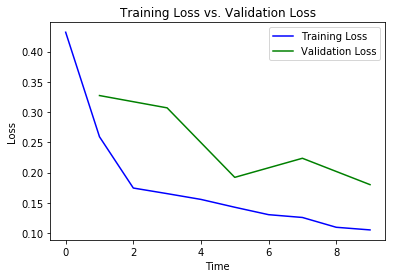

In [ ]:
# Plot of loss
plt.plot(train_loss, '-b', label = 'Training Loss')
x1, y1 = zip(*validate_loss)
plt.plot(x1, y1, '-g', label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Training Loss vs. Validation Loss")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.show()

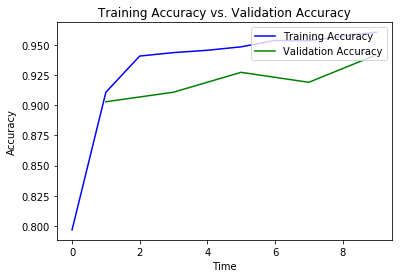

In [ ]:
# Plot of accuracy
plt.plot(train_accuracy, '-b', label = 'Training Accuracy')
x1, y1 = zip(*validate_accuracy)
plt.plot(x1, y1, '-g', label = 'Validation Accuracy')
plt.legend(loc = 'upper right')
plt.title("Training Accuracy vs. Validation Accuracy")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.show()

### Generate a prediction on the pos_test_000072.png image

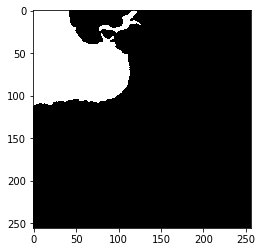

In [ ]:
# Code for testing prediction on an image
x, truth = validate_dataset[172]

model.cpu()

predicted = model(x.unsqueeze(0))

image = predicted.argmax(1)
image1 = transforms.ToPILImage()(image.float())
plt.imshow(image1, cmap = 'gray')

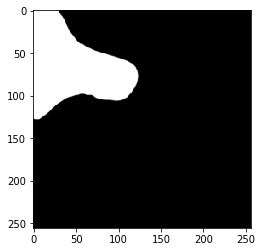

In [ ]:
# This is what the actual image looks like (so our model seemed to do a pretty 
#  good job)
real_image = transforms.ToPILImage()(truth.float())
plt.imshow(real_image, cmap = 'gray')
